# Побудова моделі Linear Regression для оцінки якості вина

## Імпорт бібліотек

In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
sns.set_theme(style='darkgrid', palette='deep')
import warnings
warnings.filterwarnings('ignore')


## Завантаження та первинний аналіз даних

In [63]:
# Завантажуємо датасети
df_red = pd.read_csv('wine-quality/winequality-red.csv', delimiter=';')
df_white = pd.read_csv('wine-quality/winequality-white.csv', delimiter=';')

# Додаємо колонку для ідентифікації типу вина
df_red['type'] = 'red'
df_white['type'] = 'white'

# Об'єднуємо два датасети в один
df = pd.concat([df_red, df_white], ignore_index=True)

# Переглядаємо загальну інформацію про дані
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  type                  6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


Перевірка на відсутність пропусків та первинний опис: числові фічі та їх розподіл.

In [64]:
# Перевірка пропусків
missing_values = df.isnull().sum()
print(missing_values)


fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
type                    0
dtype: int64


In [65]:
description = df.describe()
print(description)

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    6497.000000       6497.000000  6497.000000     6497.000000   
mean        7.215307          0.339666     0.318633        5.443235   
std         1.296434          0.164636     0.145318        4.757804   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        3.000000   
75%         7.700000          0.400000     0.390000        8.100000   
max        15.900000          1.580000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  6497.000000          6497.000000           6497.000000  6497.000000   
mean      0.056034            30.525319            115.744574     0.994697   
std       0.035034            17.749400             56.521855     0.002999   
min       0.009000             1.000000         

## Інжиніринг фіч

### Співвідношення алкоголю до густини

Вина з більш високим вмістом алкоголю, зазвичай, мають нижчу густину, тому це співвідношення може допомогти моделі визначити властивості вина, пов’язані з його міцністю.

In [66]:
df['alcohol_density_ratio'] = df['alcohol'] / df['density']

### Cпіввідношення якості до фіксованої кислотності

Може допомогти моделі краще розрізняти різні сорти вин за якістю.

In [67]:
df['quality_acidity_ratio'] = df['quality'] / df['fixed acidity']

### Перевірка на кореляцію

Перевірка на кореляцію допомагає виявити, наскільки сильно пов’язані між собою різні фічі в датасеті.

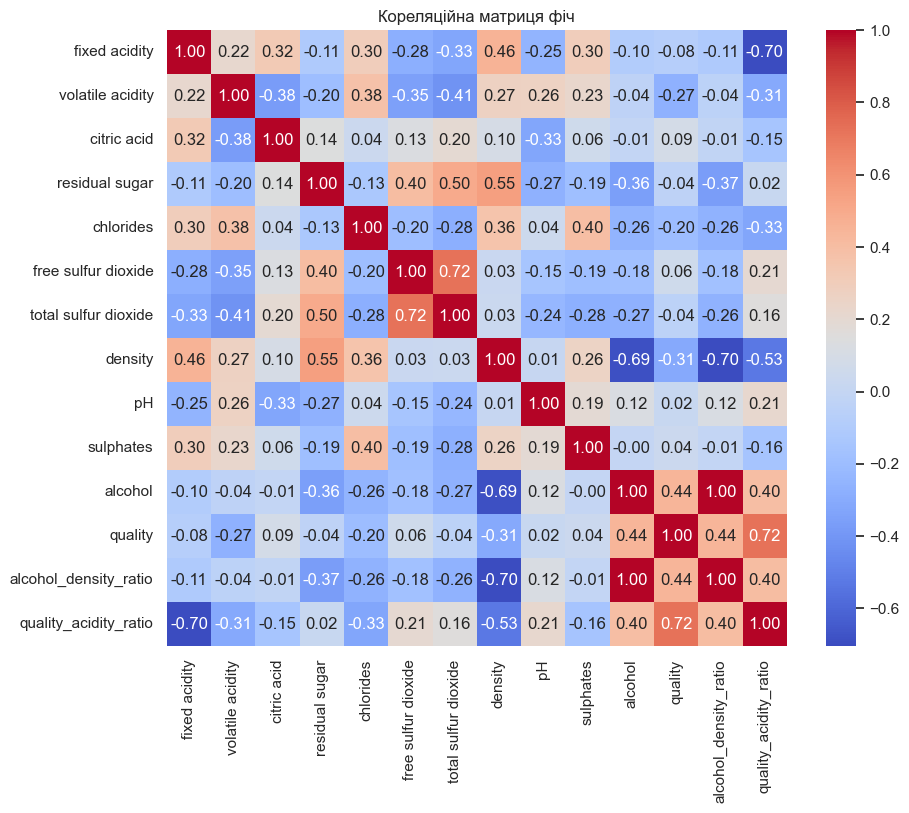

In [68]:
plt.figure(figsize=(10, 8))
#sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')

# Видаляю колонку type бо вона не є числовою а це рядкові значення
sns.heatmap(df.drop(columns=['type']).corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Кореляційна матриця фіч")
plt.show()


Кореляційна матриця візуалізує зв'язки між фічами, де:

* 1 означає високу позитивну кореляцію,
* -1 — високу негативну кореляцію,
* 0 — відсутність кореляції.

1. total sulfur dioxide і free sulfur dioxide. Це означає, що при побудові моделі можна спробувати видалити одну з цих фіч, бо сильно корелюють
2. Сильна негативна кореляція між fixed acidity та quality (-0.70). Це означає, що збільшення фіксованої кислотності часто пов’язане зі зниженням якості вина
3. Сильна негативна кореляція між density та alcohol (-0.69). Цей зв’язок показує, що вина з більш високим вмістом алкоголю зазвичай мають нижчу щільність. Це може бути пов’язано з тим, що алкоголь має меншу щільність, ніж вода.

## Масштабування фіч

Масштабуємо фічі для лінійної регресії

In [69]:
scaler = StandardScaler()

# Виключючаєм цільову фічу quality (яка є залежною змінною) та type (текстову ознаку) яка не може бути масштабована.
features = df.drop(['quality', 'type'], axis=1)
scaled_features = scaler.fit_transform(features)
scaled_df = pd.DataFrame(scaled_features, columns=features.columns)
scaled_df['quality'] = df['quality'].values

# Перевірка перших рядків
scaled_df.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,alcohol_density_ratio,quality_acidity_ratio,quality
0,0.142473,2.188833,-2.192833,-0.744778,0.569958,-1.100140,-1.446359,1.034993,1.813090,0.193097,-0.915464,-0.924166,-0.817063,5
1,0.451036,3.282235,-2.192833,-0.597640,1.197975,-0.311320,-0.862469,0.701486,-0.115073,0.999579,-0.580068,-0.588127,-1.000085,5
2,0.451036,2.553300,-1.917553,-0.660699,1.026697,-0.874763,-1.092486,0.768188,0.258120,0.797958,-0.580068,-0.589741,-1.000085,5
3,3.073817,-0.362438,1.661085,-0.744778,0.541412,-0.762074,-0.986324,1.101694,-0.363868,0.327510,-0.580068,-0.597799,-1.556342,6
4,0.142473,2.188833,-2.192833,-0.744778,0.569958,-1.100140,-1.446359,1.034993,1.813090,0.193097,-0.915464,-0.924166,-0.817063,5


## Поділ датасету

Поділяємо на тренувальну, валідаційну та тестову вибірки

* Тренувальна вибірка: використовується для навчання моделі.
* Валідаційна вибірка: використовується для налаштування та вибору гіперпараметрів, щоб уникнути перенавчання.
* Тестова вибірка: використовується тільки для остаточної оцінки продуктивності моделі на невидимих даних.

In [70]:
# X - фактично матриця з фічами (матриця ознак) 
X = scaled_df.drop('quality', axis=1)
# y - вектор з якостей. Міститсь значення які ми будем намагатись передбачити
y = scaled_df['quality']

# поділяє дані на тренувальну та тимчасову вибірки (X_temp, y_temp). Тренувальна вибірка (X_train, y_train) становить 70% даних, а тимчасова — 30%.
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# ділить тимчасову вибірку на валідаційну (X_val, y_val) та тестову (X_test, y_test) частини, по 50% кожна, тобто по 15% від початкових даних кожна
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train.shape, X_val.shape, X_test.shape


((4547, 13), (975, 13), (975, 13))

## Навчання базової моделі лінійної регресії

In [71]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

## Оцінка на валідаційній вибірці

* Середньоквадратична помилка (MSE) — середнє значення квадратів різниць між реальними та передбаченими значеннями. Менше значення означає меншу похибку.
* Середна абсолютна помилка (MAE) — середнє значення абсолютних різниць між реальними та передбаченими значеннями. Це інтерпретується як середня похибка в одиницях цільової змінної.
* Коефіцієнт детермінації (R^2), який показує, наскільки добре модель пояснює варіацію в даних. R² = 1 означає ідеальне передбачення, а R² близьке до 0 — відсутність пояснювальної сили моделі. Треба читать тут https://uk.wikipedia.org/wiki/%D0%9A%D0%BE%D0%B5%D1%84%D1%96%D1%86%D1%96%D1%94%D0%BD%D1%82_%D0%B4%D0%B5%D1%82%D0%B5%D1%80%D0%BC%D1%96%D0%BD%D0%B0%D1%86%D1%96%D1%97

In [72]:
y_val_pred = model.predict(X_val)
mse = mean_squared_error(y_val, y_val_pred)
mae = mean_absolute_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print("Середньоквадратична помилка ",mse)
print("Середня абсолютна помилка", mae) 
print("Коефіцієнт детермінації", r2)


Середньоквадратична помилка  0.07445729975567314
Середня абсолютна помилка 0.1802012123723405
Коефіцієнт детермінації 0.8999058599376693


## Підбір гіперпараметрів

Використовуємо GridSearchCV для підбору гіперпараметрів.
GridSearchCV — це інструмент для пошуку найкращої комбінації гіперпараметрів за заданим списком параметрів (param_grid).

In [73]:
param_grid = {'fit_intercept': [True, False]}
grid_search = GridSearchCV(LinearRegression(), param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

# найкращі параметри
best_params = grid_search.best_params_
best_score = -grid_search.best_score_

best_params, best_score


({'fit_intercept': True}, np.float64(0.07333406938089486))

## Оцінка результатів на тестовій вибірці

Перевірка продуктивності моделі з найкращими параметрами на тестовій вибірці

In [74]:
# отримуєм екземпляр моделі LinearRegression яка має найкращі гіперпараметри, знайдені під час пошуку з GridSearchCV.
best_model = grid_search.best_estimator_

y_test_pred = best_model.predict(X_test)

# оцінка на тестовій вибірці
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

test_mse, test_mae, test_r2

print("Середньоквадратична помилка на тестовій вибірці ",mse)
print("Середня абсолютна помилка на тестовій вибірці ", mae) 
print("Коефіцієнт детермінації на тестовій вибірці", r2)


Середньоквадратична помилка на тестовій вибірці  0.07445729975567314
Середня абсолютна помилка на тестовій вибірці  0.1802012123723405
Коефіцієнт детермінації на тестовій вибірці 0.8999058599376693


Висновок: Модель показує хорошу точність на тестовій вибірці, оскільки значення MSE і MAE низькі, а коефіцієнт детермінації R² близький до 1.